<a href="https://colab.research.google.com/github/ailsonramon/timeseries/blob/main/TS_daily_analysis_energy_2000_2021_Brazillian_Northeast_Region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução a séries temporais



Uma série temporal é definida como um conjunto de valores que se modificam em intervalos iguais de tempo. 

Exemplo
* Valor de ativos na bolsa de valores
* População de um pais
* Quantidades de passageiros 

Os modelos utilizados para descrever séries temporais são **processos estocásticos**, isto é, processos controlados por leis probabilísticas. 



Objetivos da análise de séries temporais: 

* Investigar o mecanismos gerador da série temporal, por exemplo, analisando uma série de alturas de ondas, podemos querer saber como estas ondas foram geradas. 
* Fazer previsões de valores futuros da série, sendo de curto prazo, como séries de vendas, produçõa ou estoque, ou de longo prazo, como para séries populacionais, de produtividades etc;
* Descrever apenas o comportamento da série, construção do gráfico, verificação da existência de tendência, ciclos e variações sazonais, a construição de histogramas e diagramas de dispersão.



Neste Notebook, iremos abordar os seguintes tópicos:
1.  Leitura dos arquivos e tratamento dos dados
2. Análise exploratória dos dados
3. Transformações das séries
* Há basicamente, duas razões para se transformar os dados originais: estabilizar a variância e tornar o efeito sazonal aditivo
* Uma outra razão da transformação é obter uma distribuição  para os dados mais simétricos e próximo do normal
4. Decomposição 
5. Análise de tendência

# 1. Leitura dos Arquivos e Tratamento dos Dados


##Importação das libs

In [377]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
# melhorar a visualização
pd.set_option('max_columns',170)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

##Leitura dos Arquivos

Neste exemplo iremos utilizar os dados de energia da ons.org relacionado aos dados de demanda instantanea, no período de 2000-2021, na região Nordeste do Brazil.
disponível: http://www.ons.org.br/paginas/resultados-da-operacao/historico-da-operacao

In [378]:
url = "https://raw.githubusercontent.com/ailsonramon/timeseries/main/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv"
#Select date and energy columns
col_list = ["Data Escala de Tempo 1 DM Simp 4","Selecione Tipo de DM Simp 4"]
#Import Dataframe and parse date columns for datetime64[ns]
df = pd.read_csv(url, parse_dates=[0], usecols=col_list)
df.info() 
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7701 entries, 0 to 7700
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Data Escala de Tempo 1 DM Simp 4  7701 non-null   datetime64[ns]
 1   Selecione Tipo de DM Simp 4       7701 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 120.5 KB


,Data Escala de Tempo 1 DM Simp 4,Selecione Tipo de DM Simp 4
0,2000-01-01,6205.0
1,2000-01-02,6797.0
2,2000-01-03,7024.0
3,2000-01-04,6921.0
4,2000-01-05,7025.0


Renomear as colunas e retirar dados NaN.

In [379]:
#Rename the columns
df.rename(columns = {'Data Escala de Tempo 1 DM Simp 4':'Date','Selecione Tipo de DM Simp 4':'Megawatts(MW)'}, inplace = True)
#Remove NaN date
df = df.dropna()
df.info() 
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7701 entries, 0 to 7700
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7701 non-null   datetime64[ns]
 1   Megawatts(MW)  7701 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 180.5 KB


,Date,Megawatts(MW)
0,2000-01-01,6205.0
1,2000-01-02,6797.0
2,2000-01-03,7024.0
3,2000-01-04,6921.0
4,2000-01-05,7025.0


Em seguida, transformaremos a coluna 'Date' como a coluna indexadora dos demais utilizando o comando ```DataFrame.set_index()```



In [380]:
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7701 entries, 2000-01-01 00:00:00 to 2021-01-31 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Megawatts(MW)  7701 non-null   float64
dtypes: float64(1)
memory usage: 120.3 KB


Podemos perceber que a coluna 'Data' desaparece, porque ela deixa de ser uma coluna e passa a se comportar como um índice

Essa transformação inicial é necessária para a plotagem do gráfica da série temporal. Onde por definição ele utiliza o eixo X o índice que indicamos na tabela. 

###Estrutura dos dados

Podemos usar as vantagens oferecidas pelo formatado ```DatetimeIndex``` e formatar nosso DataFrame para o formatado [**Long-form**](https:////seaborn.pydata.org/tutorial/data_structure.html)

In [381]:
df["year"] =  df.index.year
df["month"] = df.index.month
df["week"] = df.index.weekday
df.head()

,Megawatts(MW),year,month,week
Date,,,,
2000-01-01,6205.0,2000,1,5
2000-01-02,6797.0,2000,1,6
2000-01-03,7024.0,2000,1,0
2000-01-04,6921.0,2000,1,1
2000-01-05,7025.0,2000,1,2


Esse formatado facilidade bastante na análise por parte.

#2. Análise exploratória dos dados

A análise estatística é um processo de compreensão de como as variáveis ​​em um conjunto de dados se relacionam entre si e como essas relações dependem de outras variáveis. A visualização pode ser um componente central desse processo porque, quando os dados são visualizados corretamente, o sistema visual humano pode ver tendências e padrões que indicam um relacionamento.

##Resumo Estatístico

###Média, Mediana, Variância, Q1 e Q3

In [382]:
df['Megawatts(MW)'].describe()

count     7701.000000
mean      9393.276347
std       1814.601734
min       5087.900000
25%       7976.700000
50%       9324.780000
75%      10914.150000
max      13306.963000
Name: Megawatts(MW), dtype: float64

##Análise Gráfica


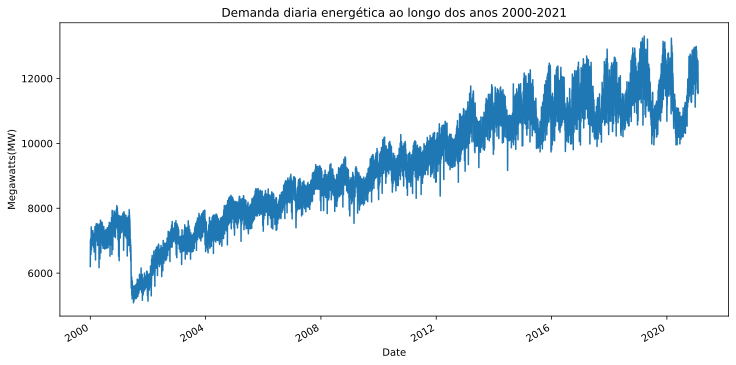

In [383]:
df['Megawatts(MW)'].plot(figsize=(12,6))
plt.title("Demanda diaria energética ao longo dos anos 2000-2021")
plt.ylabel("Megawatts(MW)")
plt.show()

Uma análise visual inicial é possível verificar tendência de crescimento e sazonalidade na série temporal a ser examinada.

###Análise Anual

#####Gráfico de linha

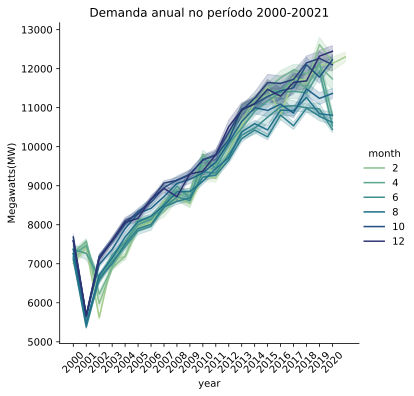

In [415]:
sns.relplot(data=df, x="year", y="Megawatts(MW)", hue="month", kind="line", palette="crest")
plt.title("Demanda anual no período 2000-20021")
plt.xticks(np.arange(2000,2021,1), rotation=45)
plt.show()

Ao longo dos anos a demanda energética mostra em crescimento

#####Boxplot

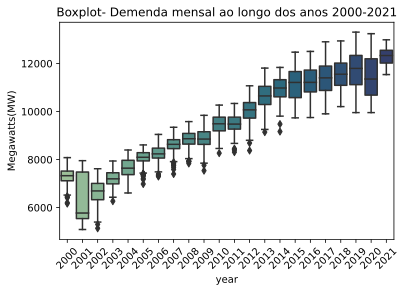

In [414]:
sns.boxplot(data=df, x='year', y='Megawatts(MW)', palette="crest")
plt.xticks(rotation=45)
plt.title('Boxplot- Demenda mensal ao longo dos anos 2000-2021')
plt.show()

####Histograma

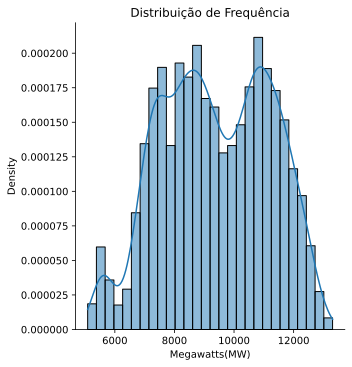

In [417]:
sns.displot(data=df, kind='hist', kde=True, stat="density", x ="Megawatts(MW)")
plt.title("Distribuição de Frequência")
plt.show()

Analisando o gráfico das médias móveis é possível verificar uma tendência de crescimento e um grau de sazonalidade.

Verificação de Sazonalidade, no período mensal. 



####Média móvel

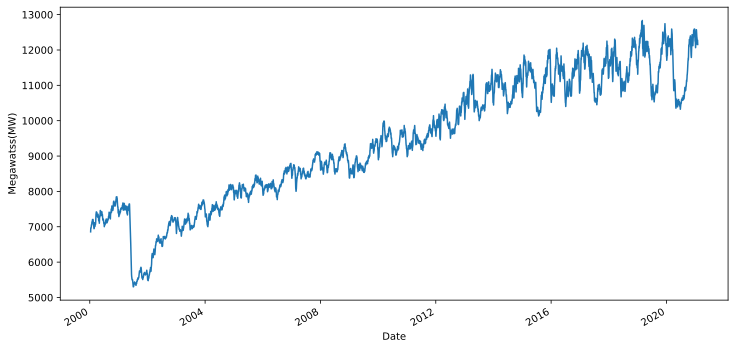

In [396]:
df["Megawatts(MW)"].rolling(12).mean().plot(figsize=(12,6))
plt.ylabel("Megawatss(MW)")
plt.show()

####Análise Mensal

####Estrutura de dados **Wide-form** para melhor análise dos meses

In [388]:
x = df.groupby(["year", "month"])["Megawatts(MW)"].mean()
df_wide = x.unstack()
df_wide.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2000,7006.000000,7079.517241,7267.735484,7250.000000,7367.354839,7172.266667,7121.645161,7253.477419,7371.763333,7589.177419,7682.820000,7593.941935
2001,7416.719355,7525.896429,7582.203226,7460.503333,7265.154839,5541.440000,5376.812903,5451.838710,5667.013333,5665.641935,5646.013333,5670.300000
2002,5620.593548,5982.232143,6219.254839,6550.773333,6633.738710,6568.826667,6625.387097,6713.351613,6980.776667,7172.693548,7184.543333,7112.304516
2003,7098.160645,6881.578929,6907.893226,7151.284333,7229.410645,7059.194000,6996.116774,7145.355161,7366.692667,7569.277419,7598.930000,7604.600000
2004,7184.319355,7198.251724,7458.206452,7529.793333,7567.158065,7434.856667,7504.683871,7689.051613,7899.770000,8021.996774,8097.356667,8060.867742


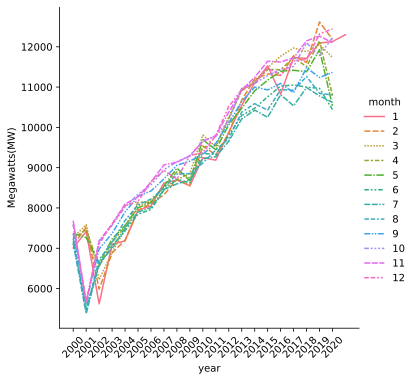

In [403]:
sns.relplot(data=df_wide, kind="line")
plt.xticks(np.arange(2000,2021,1), rotation=45)
plt.ylabel("Megawatts(MW)")
plt.show()

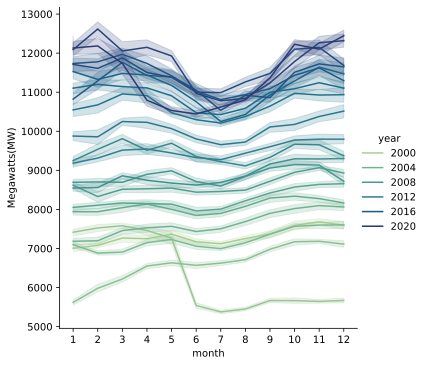

In [413]:
sns.relplot(data=df, x="month", y="Megawatts(MW)", hue="year", kind="line", palette="crest");
plt.xticks(range(1, 13))
plt.show()

A gente consegue perceber pelo gráfico que ao longo dos meses 6 e 8 tem uma tendência de decrecimento e um grau de sazonalidade. 

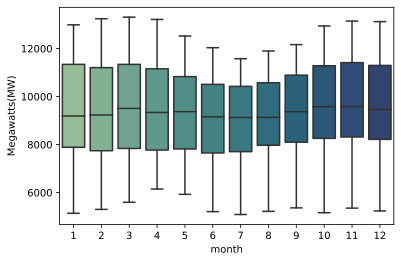

In [412]:
sns.boxplot(x='month', y='Megawatts(MW)', data=df, palette="crest");

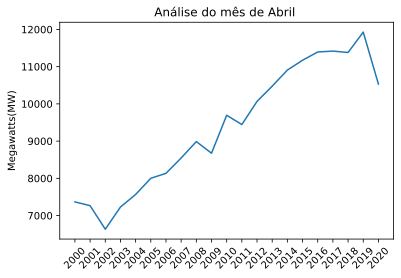

In [392]:
plt.plot(df_wide[5])
plt.title("Análise do mês de Abril ")
plt.xticks(np.arange(2000,2021,1), rotation=45)
plt.ylabel("Megawatts(MW)")
plt.show()

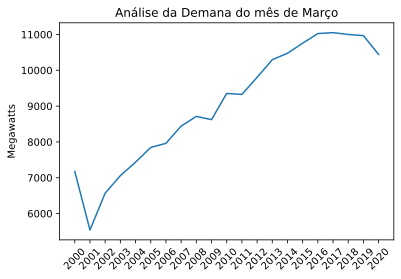

In [393]:
plt.plot(df_wide[6])
plt.xticks(np.arange(2000,2021,1), rotation=45)
plt.ylabel("Megawatts")
plt.title("Análise da Demana do mês de Março")
plt.show()

###Análise semanal

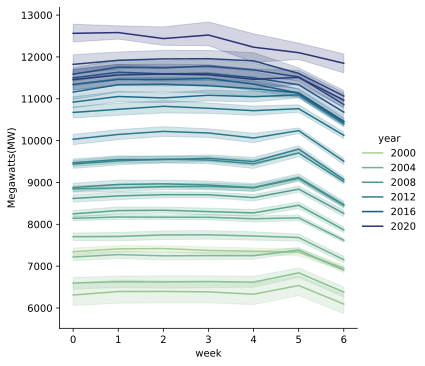

In [410]:
sns.relplot(data=df, x="week", y="Megawatts(MW)", hue="year", kind="line", palette="crest");

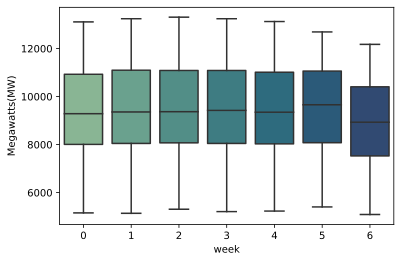

In [411]:
sns.boxplot(data=df, x="week", y="Megawatts(MW)", palette="crest")


#3. Tranformações

In [ ]:
#Select a percentage from the time series
data_proportion = lambda serie, percent=1.0: serie[-int(percent * len(serie)):]

#4. Decomposição

#5. Análise de Tendência

##Característica estatísticas

Verificação de média e variância

In [ ]:
X = df['energy']
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()

var1, var2 = X1.var(), X2.var()
print("Media da primeira parte: %f, \nMedia da segunda parte:%f" %(mean1, mean2))
#print(f"variancia1:{var1} \nvariancia2:{var2}")
print("Variancia1:%f\nVariancia2:%f" % (var1,var2))

Tanto a média quanto a variância contém pouca variação entre as metades das amostras. 
Isso também indica que a série é estacionária

In [ ]:
def plot_mean_var_ts(timeseries):
  #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.plot(figsize=(12,6))
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [ ]:
def plot_mean_var(ts):
  m = ts.rolling(12).mean()
  v = ts.rolling(12).std()
  orig = plt.plot(ts, color='blue',label='Original')
  mean = plt.plot(m, color='red', label='Rolling Mean')
  std = plt.plot(v, color='black', label = 'Rolling std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)


In [ ]:
def test_dickfuller(timeseries):
  #Reference:https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
  #timeseries.T.squeeze()
  result = adfuller(x=timeseries.energy,autolag='AIC')
  dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  print('ADF   statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)


In [ ]:
def test_kpss(timeseries):
  print('\nResults of KPSS Test:')
  result = kpss(timeseries, regression='c')
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  for key, value in result[3].items():
      print('Critial Values:')
      print(f'   {key}, {value}')

In [ ]:
def check_stationarity(timeseries):
  plot_mean_var(timeseries)
  test_dickfuller(timeseries)
  test_kpss(timeseries)

In [ ]:
check_stationarity(ts_08_percent)

In [ ]:
ts_log = np.log(ts_50_per)
plt.plot(ts_log)
check_stationarity(ts_log)

In [ ]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
import seaborn as sns
import statsmodels.api as sm
#Decompose a time serie
decomposition = sm.tsa.seasonal_decompose(df_02_percent, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()